# Homework

You need to train the model and get score as big as you can

Dataset: https://disk.yandex.ru/d/gcGKZ_KsXZN4VA

### Prepare part

In [2]:
import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import tqdm.notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data
import torchaudio
import urllib
import random
import gc

from IPython.display import clear_output

%matplotlib inline

In [ ]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/gcGKZ_KsXZN4VA'
final_url = base_url + urllib.parse.urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
!wget -O data.tar.gz "{download_url}"
# !tar -xf data.tar.gz
!mkdir /kaggle/tmp
!tar -xf data.tar.gz -C /kaggle/tmp

--2024-11-29 10:59:37--  https://downloader.disk.yandex.ru/disk/a1557e47c4663b56e5d67293b3d8adac56df5a855511a31ea48d4c843cc170e8/6749d6d8/gtj3WQiuHGabqHv6W0pVHEXbZdC1bwqiumxRXdqgzpJ223zLuKxFz6bilpTWCZ6rE1Zoh7DdQ82OIQqL0xL28A%3D%3D?uid=0&filename=ml_trains.tar.gz&disposition=attachment&hash=ER8JmpAegW%2B8Cl46xAlRyrF9NAw2fVICg53vs0t17nID28omurL9sCwKmDpfdG9qq/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=application%2Fx-gzip&owner_uid=163052607&fsize=10315472612&hid=05181040c34ed1b1730124aef7dbd3fc&media_type=compressed&tknv=v2
Resolving downloader.disk.yandex.ru (downloader.disk.yandex.ru)... 77.88.21.127, 2a02:6b8::2:127
Connecting to downloader.disk.yandex.ru (downloader.disk.yandex.ru)|77.88.21.127|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s315vla.storage.yandex.net/rdisk/a1557e47c4663b56e5d67293b3d8adac56df5a855511a31ea48d4c843cc170e8/6749d6d8/gtj3WQiuHGabqHv6W0pVHEXbZdC1bwqiumxRXdqgzpJ223zLuKxFz6bilpTWCZ6rE1Zoh7DdQ82OIQqL0xL28A==?uid

In [5]:
# DEVICE = 'cpu' # also you can use "cuda" for gpu and "mps" for apple silicon
DEVICE = 'cuda' if torch.cuda.is_available else 'cpu'
# DATADIR = 'ml_trains_data'
# DATADIR = '/kaggle/working/ml_trains_data'
LOADER_WORKERS = 0
DEVICE

'cuda'

In [6]:
def time_masking(mfcc, mask_size, num_masks):
    """
    Time masking: случайное обрезание части MFCC по временной оси.
    """
    time_dim = mfcc.size(1)  # временная ось
    for _ in range(num_masks):
        effective_mask_size = min(mask_size, time_dim)  # Размер маски
        t = random.randint(0, time_dim - effective_mask_size)  # Случайная позиция
        mfcc[:, t:t + effective_mask_size] = 0  # Маскируем временную ось
    return mfcc


def freq_masking(mfcc, mask_size, num_masks):
    """
    Frequency masking: случайное обрезание части MFCC по частотной оси.
    """
    freq_dim = mfcc.size(0)  # частотная ось
    for _ in range(num_masks):
        effective_mask_size = min(mask_size, freq_dim)  # Размер маски
        f = random.randint(0, freq_dim - effective_mask_size)  # Случайная позиция
        mfcc[f:f + effective_mask_size, :] = 0  # Маскируем частотную ось
    return mfcc


def spec_augment(mfcc, time_mask_max_size=50, freq_mask_max_size=10, num_time_masks=1, num_freq_masks=1):
    """
    Применение SpecAugment (time masking и freq masking) к MFCC.
    """
    # Вначале применяем time masking
    mfcc = time_masking(mfcc, mask_size=random.randint(10, time_mask_max_size), num_masks=num_time_masks)

    # Потом применяем frequency masking
    mfcc = freq_masking(mfcc, mask_size=random.randint(5, freq_mask_max_size), num_masks=num_freq_masks)

    return mfcc

In [7]:
class Dataset(torch_data.Dataset):
    def __init__(self, split_part: str, datadir: str, feats: nn.Module, read_labels=True, apply_specaug=False):
        super().__init__()
        data = pd.read_csv(os.path.join(datadir, f'{split_part}.tsv'), sep='\t')
        if read_labels:
            labels = {key: idx for idx, key in enumerate(sorted(set(data.label.values)))}
            self._idx_to_label = {idx: key for idx, key in enumerate(sorted(set(data.label.values)))}
        self._classes = len(labels) if read_labels else 30
        self._feats = feats
        self._ytids = []
        self._pathes = []
        self._labels = []
        self.apply_specaug = apply_specaug
        for _, row in data.iterrows():
            path = os.path.join(datadir, 'clips', f'{row.YTID}.flac')
            if os.path.exists(path):
                self._ytids.append(row.YTID)
                self._pathes.append(path)
                self._labels.append(labels[row.label] if read_labels else 0)

    def __getitem__(self, index):
        try:
            waveform, sample_rate = torchaudio.load(self._pathes[index])
        except Exception as err:
            logging.error("Can't read file %s", self._pathes[index])
            raise err
        assert sample_rate == 16000
        assert waveform.shape[0] == 1
        feats = self._feats(waveform)[0]
        if self.apply_specaug:
            feats = spec_augment(feats)
        return (feats, self._labels[index])

    def __len__(self) -> int:
        return len(self._pathes)

    def classes(self) -> int:
        return self._classes


def collate_fn(batch):
    max_length = max(item[0].shape[1] for item in batch)
    X = torch.zeros((len(batch), batch[0][0].shape[0], max_length))
    for idx, item in enumerate(batch):
        X[idx, :, :item[0].shape[1]] = item[0]
    targets = torch.tensor([item[1] for item in batch], dtype=torch.long).reshape(len(batch), 1)
    return (X, targets)

### Feats part

In [8]:
# Try to use LogMelSpectrogram or MFCC to achive better score
class LogMelSpectrogram(nn.Module):
    # pass
    def __init__(self, n_mels):
        super().__init__()
        self.mel_spectrogram = torchaudio.transforms.MelSpectrogram(n_mels=n_mels)
        self.amplitude_to_db = torchaudio.transforms.AmplitudeToDB()

    def forward(self, waveform):
        mel_spec = self.mel_spectrogram(waveform)
        log_mel_spec = self.amplitude_to_db(mel_spec)

        return log_mel_spec


# FBANK 40 by default, but you can choose something else
FEATS = 40
# transform = torchaudio.transforms.MelSpectrogram(n_mels=FEATS)
transform = LogMelSpectrogram(n_mels=FEATS)
# transform = torchaudio.transforms.MFCC(n_mfcc=FEATS)

# trainset = Dataset('train', 'data', transform)
# testset = Dataset('eval', 'data', transform)
trainset = Dataset('train', '/kaggle/tmp/ml_trains_data/', transform, read_labels=True, apply_specaug=False)
trainset_aug = Dataset('train', '//kaggle/tmp/ml_trains_data/', transform, read_labels=True, apply_specaug=True)
testset = Dataset('eval', '/kaggle/tmp/ml_trains_data/', transform, read_labels=False, apply_specaug=False)
N_CLASSES = trainset.classes()
assert N_CLASSES == 30

### Eval part

Write balanced accuracy:
$$BAcc = \frac{1}{classes}\sum_{c = 1}^{classes} \frac{\sum_i^n I(y_i = p_i = c)}{\sum_i^n I(y_i = c)}$$

Where:
- $y_i$ -- target class for $i$ element
- $p_i$ -- predicted class for $i$ element

In [9]:
# Get list of pairs (target_class, predicted_class)
def balanced_accuracy(items: list[tuple[int, int]], classes=N_CLASSES) -> float:
    # <YOUR CODE IS HERE>
    true_dct = {}
    pred_dct = {}
    for i in range(len(items)):
        true_dct[items[i][0]] = true_dct.get(items[i][0], 0) + 1
        if items[i][0] == items[i][1]:
            pred_dct[items[i][1]] = pred_dct.get(items[i][1], 0) + 1
    acc = 0
    for true_key, pred_key in zip(sorted(true_dct), sorted(pred_dct)):
        acc += pred_dct[pred_key] / true_dct[true_key]

    return acc / classes

In [10]:
assert np.isclose(balanced_accuracy([(0, 0), (0, 0), (1, 1)], 2), 1.0)
assert np.isclose(balanced_accuracy([(0, 1), (1, 0)], 2), 0.0)
assert np.isclose(balanced_accuracy([(0, 0), (0, 0), (1, 0)], 2), 0.5)
assert np.isclose(balanced_accuracy([(0, 0), (1, 1), (0, 0), (0, 0), (1, 0), (0, 1)], 2), 0.625)
assert np.isclose(balanced_accuracy([(1, 1), (0, 1), (2, 2)], 3), 0.66666666666666)

### Train part
Train some model with as big balanced accuracy as you can

You can train any model you want. The only limitation is that it must be trained from scratch on the data provided in the task. For example you can choose model from:
- DNN
- CNN 1d
- CNN 2d
- Transformer
- RNN
- mixes of given models

Hints:
- No need to train large models for this task. 10 million parameters is more than you need.
- Watch to overfitting, try to add Augmentation, Dropout, BatchNorm, L1/L2-Regulatization or something else.
- Use poolings or strides to reduce time-dimenstion. It is better to reduce the dimension gradually rather than at the end.
- Try different features (mel-spec, log-mel-spec, mfcc)

In [54]:
def stage(
    model: nn.Module,
    data: torch_data.Dataset,
    opt: optim.Optimizer,
    batch_size: int = 256,
    train: bool = True
):
    loader = torch_data.DataLoader(
        data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=LOADER_WORKERS,
        collate_fn=collate_fn
    )
    if train:
        model.train()
    else:
        model.eval()
    loss_sum, batches = 0.0, 0
    pred_pairs = []
    for X, Y in tqdm.tqdm(loader):
        pred = model.forward(X.to(DEVICE))
        loss = F.cross_entropy(pred.squeeze(), Y.squeeze().to(DEVICE))
        if train:
            opt.zero_grad()
            loss.backward()
            opt.step()
        loss_sum += loss.item()
        batches += 1
        with torch.no_grad():
            pred_pairs.extend(zip(
                Y.data.numpy().reshape(-1),
                torch.argmax(pred, dim=1).cpu().data.numpy().reshape(-1)
            ))
    return loss_sum / batches, balanced_accuracy(pred_pairs)


def train(
    model: nn.Module,
    opt,
    # batch_size: int = 256,
    batch_size = 64,
    epochs: int = 20,
):
    global_val_acc = 0
    name = ''

    train_data, val_data = torch.utils.data.random_split(trainset, (0.9, 0.1), generator=torch.Generator().manual_seed(42))
    # train_data, val_data = torch.utils.data.random_split(trainset_aug, (0.9, 0.1), generator=torch.Generator().manual_seed(42))
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    for epoch in range(epochs):
        train_loss, train_acc = stage(model, train_data, opt, batch_size=batch_size)
        val_loss, val_acc = stage(model, val_data, opt, batch_size=batch_size, train=False)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        clear_output()
        fig, axis = plt.subplots(1, 2, figsize=(15, 7))
        axis[0].plot(np.arange(1, epoch + 2), train_losses, label='train')
        axis[0].plot(np.arange(1, epoch + 2), val_losses, label='val')
        axis[1].plot(np.arange(1, epoch + 2), train_accs, label='train')
        axis[1].plot(np.arange(1, epoch + 2), val_accs, label='val')
        axis[0].set(xlabel='epoch', ylabel='CE Loss')
        axis[1].set(xlabel='epoch', ylabel='Accuracy')
        fig.legend()
        plt.show()
        print(f'Epoch {epoch + 1}.')
        print(f'Train loss {train_loss}. Train accuracy {train_acc}.')
        print(f'Test loss {val_loss}. Test accuracy {val_acc}')
        if val_acc > global_val_acc:
            name = f'model_{epoch}_{val_acc}_{train_acc}_params.pth'
            global_val_acc = val_acc
            torch.save({ 'model_state_dict': model.state_dict(), 'optimizer_state_dict': opt.state_dict(), }, name)

In [57]:
# MFCC; Stack of conv1d + pooling between these conv + pooling/flatten + dense layers
# 38.47
# class Model(nn.Module):
#     def __init__(self, in_dim=FEATS, out_dim=N_CLASSES):
#         super().__init__()
#         hid_dim = 128
#         self.conv = nn.Sequential(nn.Conv1d(in_channels=in_dim,
#                                             out_channels=hid_dim,
#                                             kernel_size=3,
#                                             stride=1,
#                                             padding=1),
#                                   nn.BatchNorm1d(num_features=hid_dim),
#                                   nn.ReLU(),
#                                   nn.MaxPool1d(kernel_size=2, stride=2),

#                                   nn.Dropout(0.5),

#                                   nn.Conv1d(in_channels=hid_dim,
#                                             out_channels=2 * hid_dim,
#                                             kernel_size=3,
#                                             stride=1,
#                                             padding=1),
#                                   nn.BatchNorm1d(num_features=2 * hid_dim),
#                                   nn.ReLU(),
#                                   nn.MaxPool1d(kernel_size=2, stride=2),

#                                   nn.Conv1d(in_channels=2 * hid_dim,
#                                             out_channels=4 * hid_dim,
#                                             kernel_size=3,
#                                             stride=1,
#                                             padding=1),
#                                   nn.BatchNorm1d(num_features=4 * hid_dim),
#                                   nn.ReLU(),
#                                   nn.MaxPool1d(kernel_size=2, stride=2),

#                                   nn.Dropout(0.5),

#                                   nn.Conv1d(in_channels=4 * hid_dim,
#                                             out_channels=8 * hid_dim,
#                                             kernel_size=3,
#                                             stride=1,
#                                             padding=1),
#                                   nn.BatchNorm1d(num_features=8 * hid_dim),
#                                   nn.ReLU(),
#                                   nn.MaxPool1d(kernel_size=2, stride=2))

#         self.global_pool = nn.AdaptiveAvgPool1d(1)
#         self.flatten = nn.Flatten()
#         self.classifier = nn.Sequential(nn.Linear(in_features=8 * hid_dim,
#                                                   out_features=2048),
#                                         nn.ReLU(),
#                                         nn.Linear(in_features=2048,
#                                                   out_features=4096),
#                                         nn.ReLU(),

#                                         nn.BatchNorm1d(num_features=4096),
#                                         nn.Dropout(0.5),

#                                         nn.Linear(in_features=4096,
#                                                   out_features=512),
#                                         nn.ReLU(),
#                                         nn.Linear(in_features=512,
#                                                   out_features=out_dim))


#     def forward(self, X):
#         X = self.conv(X)
#         X = self.global_pool(X)
#         X = self.flatten(X)
#         return self.classifier(X)


# LogMelSpectrogram + Conv1d + Depthwise + LSTM
# 43.37
# class Model(nn.Module):
#     def __init__(self, in_dim=FEATS, out_dim=N_CLASSES):
#         super().__init__()
#         hid_dim = 256
#         self.conv = nn.Sequential(nn.Conv1d(in_channels=in_dim,
#                                             out_channels=hid_dim,
#                                             kernel_size=3,
#                                             stride=1,
#                                             padding=1),
#                                   nn.BatchNorm1d(num_features=hid_dim),
#                                   nn.ReLU(),
#                                   nn.MaxPool1d(kernel_size=2, stride=2),
#                                   nn.Dropout(p=0.25),

#                                   nn.Conv1d(in_channels=hid_dim,
#                                             out_channels=hid_dim,
#                                             kernel_size=3,
#                                             stride=1,
#                                             padding=1,
#                                             groups=hid_dim),
#                                   nn.Conv1d(in_channels=hid_dim,
#                                             out_channels=2 * hid_dim,
#                                             kernel_size=1),
#                                   nn.BatchNorm1d(num_features=2 * hid_dim),
#                                   nn.ReLU(),
#                                   nn.MaxPool1d(kernel_size=2, stride=2),
#                                   nn.Dropout(p=0.25),

#                                   nn.Conv1d(in_channels=2 * hid_dim,
#                                             out_channels=2 * hid_dim,
#                                             kernel_size=3,
#                                             stride=1,
#                                             padding=2,
#                                             dilation=2),
#                                   nn.BatchNorm1d(num_features=2 * hid_dim),
#                                   nn.ReLU(),

#                                   nn.Conv1d(in_channels=2 * hid_dim,
#                                             out_channels=2 * hid_dim,
#                                             kernel_size=3,
#                                             stride=1,
#                                             padding=1,
#                                             groups=hid_dim),
#                                   nn.Conv1d(in_channels=2 * hid_dim,
#                                             out_channels=4 * hid_dim,
#                                             kernel_size=1),
#                                   nn.BatchNorm1d(num_features=4 * hid_dim),
#                                   nn.ReLU(),
#                                   nn.AdaptiveMaxPool1d(output_size=1),
#                                   nn.Dropout(p=0.25))

#         self.lstm = nn.LSTM(input_size=4 * hid_dim, hidden_size=2 * hid_dim, batch_first=True, bidirectional=True)

#         self.classifier = nn.Sequential(nn.Linear(in_features=4 * hid_dim,
#                                                   out_features=2 * hid_dim),
#                                         nn.BatchNorm1d(num_features=2 * hid_dim),
#                                         nn.ReLU(),
#                                         nn.Dropout(p=0.25),
#                                         nn.Linear(in_features=2 * hid_dim,
#                                                   out_features=out_dim))

#     def forward(self, X):
#         X = self.conv(X)
#         X = X.transpose(1, 2)
#         X, _ = self.lstm(X)
#         X = X.transpose(1, 2)
#         X = X.squeeze(2)

#         return self.classifier(X)


# 50.67
class Model(nn.Module):
    def __init__(self, in_dim=FEATS, out_dim=N_CLASSES):
        super().__init__()
        hid_dim = 256

        self.conv2d = nn.Sequential(nn.Conv2d(in_channels=1,
                                              out_channels=hid_dim,
                                              kernel_size=(3, 3),
                                              stride=(1, 2),
                                              padding=(1, 1)),
                                    nn.BatchNorm2d(num_features=hid_dim),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
                                    nn.Dropout(p=0.25),)

        self.conv1d = nn.Sequential(nn.Conv1d(in_channels=hid_dim, out_channels=hid_dim, kernel_size=3, stride=1, padding=1),
                                    nn.BatchNorm1d(num_features=hid_dim),
                                    nn.ReLU(),
                                    nn.MaxPool1d(kernel_size=2, stride=2),
                                    nn.Dropout(p=0.25),
                                    
                                    nn.Conv1d(in_channels=hid_dim, out_channels=2 * hid_dim, kernel_size=3, stride=1, padding=1),
                                    nn.BatchNorm1d(num_features=2 * hid_dim),
                                    nn.ReLU(),
                                    nn.AdaptiveMaxPool1d(output_size=50))

        self.gru = nn.GRU(input_size=2 * hid_dim, hidden_size=hid_dim, batch_first=True, bidirectional=True)

        self.classifier = nn.Sequential(nn.Linear(in_features=2 * hid_dim, out_features=hid_dim),
                                        nn.BatchNorm1d(hid_dim),
                                        nn.ReLU(),
                                        nn.Dropout(p=0.5),
                                        nn.Linear(in_features=hid_dim, out_features=out_dim))

    def forward(self, X):
        X = X.unsqueeze(1)
        X = self.conv2d(X)
        X = X.flatten(start_dim=2)
        X = self.conv1d(X)
        X = X.transpose(1, 2)
        X, _ = self.gru(X)
        X = X.mean(dim=1)

        return self.classifier(X)


# 48.67
# class Model(nn.Module):
#     def __init__(self, in_dim=FEATS, out_dim=N_CLASSES):
#         super().__init__()
#         hid_dim = 256

#         self.conv2d = nn.Sequential(nn.Conv2d(in_channels=1,
#                                               out_channels=hid_dim,
#                                               kernel_size=(3, 3),
#                                               stride=(1, 2),
#                                               padding=(1, 1)),
#                                     nn.BatchNorm2d(num_features=hid_dim),
#                                     nn.ReLU(),
#                                     nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
#                                     nn.Dropout(p=0.25),)

#         self.conv1d = nn.Sequential(nn.Conv1d(in_channels=hid_dim, out_channels=hid_dim, kernel_size=3, stride=1, padding=1),
#                                     nn.BatchNorm1d(num_features=hid_dim),
#                                     nn.ReLU(),
#                                     nn.MaxPool1d(kernel_size=2, stride=2),
#                                     nn.Dropout(p=0.25),

#                                     nn.Conv1d(in_channels=hid_dim, out_channels=2 * hid_dim, kernel_size=3, stride=1, padding=1),
#                                     nn.BatchNorm1d(num_features=2 * hid_dim),
#                                     nn.ReLU(),
#                                     nn.AdaptiveMaxPool1d(output_size=50))

#         self.gru = nn.GRU(input_size=2 * hid_dim, hidden_size=hid_dim, batch_first=True, bidirectional=True)

#         self.classifier = nn.Sequential(nn.Linear(in_features=2 * hid_dim, out_features=2 * hid_dim),
#                                         nn.BatchNorm1d(2 * hid_dim),
#                                         nn.ReLU(),
#                                         nn.Dropout(p=0.4),
#                                         nn.Linear(in_features=2 * hid_dim, out_features=hid_dim),
#                                         nn.BatchNorm1d(hid_dim),
#                                         nn.ReLU(),
#                                         nn.Dropout(p=0.4),
#                                         nn.Linear(in_features=hid_dim, out_features=out_dim))

#     def forward(self, X):
#         X = X.unsqueeze(1)
#         X = self.conv2d(X)
#         X = X.flatten(start_dim=2)
#         X = self.conv1d(X)
#         X = X.transpose(1, 2)
#         X, _ = self.gru(X)
#         X = X.mean(dim=1)

#         return self.classifier(X)

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters")
model

The model has 1,917,470 trainable parameters


Model(
  (conv2d): Sequential(
    (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
  )
  (conv1d): Sequential(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): AdaptiveMaxPool1d(output_size=50)
  )
  (gru): GRU(512, 256, batch_first=True, bidirectional=True)
  (classifier): Sequential(
    (0): Lin

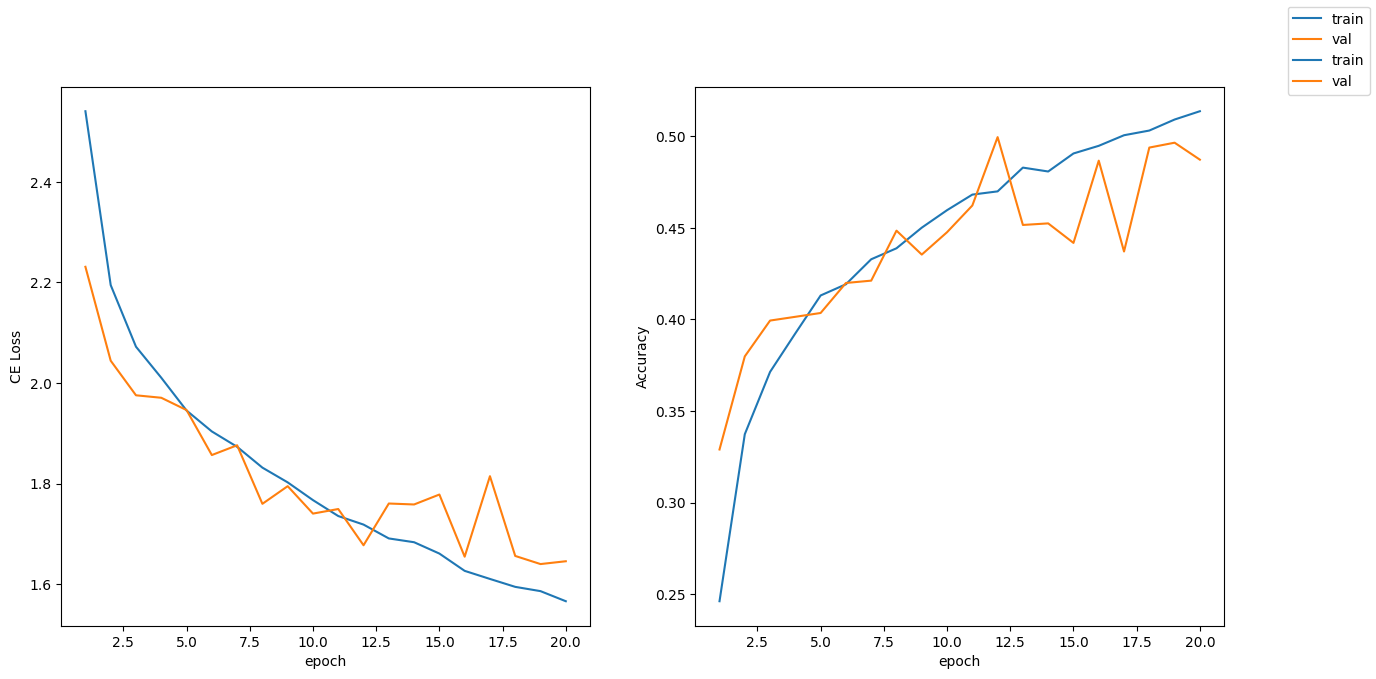

Epoch 20.
Train loss 1.5661487721492282. Train accuracy 0.5136123387414551.
Test loss 1.6456186829543695. Test accuracy 0.48716446263994645


In [35]:
model = Model().to(DEVICE)
opt = optim.Adam(model.parameters())
train(model, opt)

In [40]:
torch.save({ 'model_state_dict': model.state_dict(), 'optimizer_state_dict': opt.state_dict(), }, '/kaggle/working/ninth_params.pth')

In [58]:
checkpoint = torch.load('ninth_params.pth', weights_only=True)

model = Model().to(DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])

opt = optim.Adam(model.parameters())
opt.load_state_dict(checkpoint['optimizer_state_dict'])

model.train()

Model(
  (conv2d): Sequential(
    (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
  )
  (conv1d): Sequential(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): AdaptiveMaxPool1d(output_size=50)
  )
  (gru): GRU(512, 256, batch_first=True, bidirectional=True)
  (classifier): Sequential(
    (0): Lin

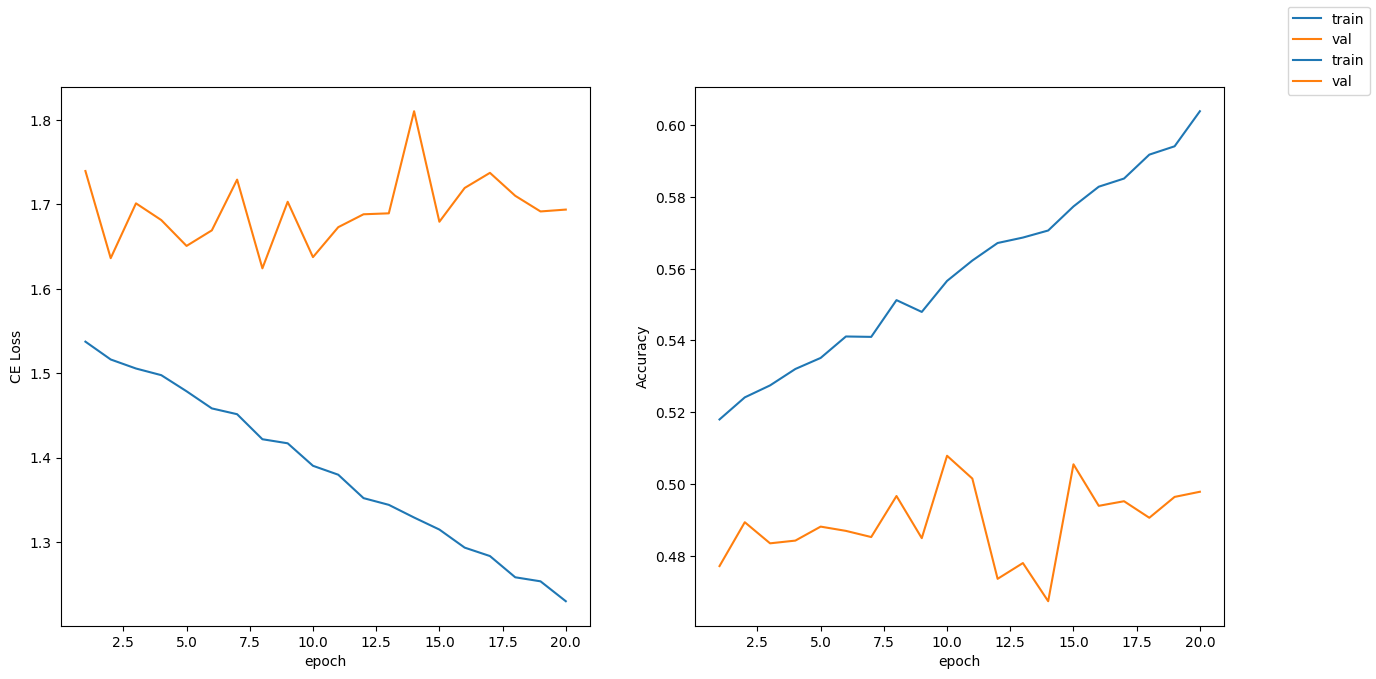

Epoch 20.
Train loss 1.2297808597404458. Train accuracy 0.6039046441241063.
Test loss 1.6938224129560517. Test accuracy 0.49783805307314394


In [59]:
# Change original trainset to trainset_aug
train(model, opt)

In [34]:
torch.save({ 'model_state_dict': model.state_dict(), 'optimizer_state_dict': opt.state_dict(), }, 'tenth_try_params.pth')

### Prediction part

Prepare result file and send it to Yandex.Contest

In [60]:
# checkpoint = torch.load('tenth_try_params.pth', weights_only=True)
checkpoint = torch.load('/kaggle/working/model_9_0.5078703412576517_0.5566051887872088_params.pth', weights_only=True)

model = Model().to(DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])

opt = optim.Adam(model.parameters())
opt.load_state_dict(checkpoint['optimizer_state_dict'])

model.eval()

Model(
  (conv2d): Sequential(
    (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
  )
  (conv1d): Sequential(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): AdaptiveMaxPool1d(output_size=50)
  )
  (gru): GRU(512, 256, batch_first=True, bidirectional=True)
  (classifier): Sequential(
    (0): Lin

In [62]:
result = []
for idx, ytid in enumerate(testset._ytids):
    feats, _ = testset[idx]
    predict = torch.argmax(model.forward(feats.reshape(1, FEATS, -1).to(DEVICE)), dim=1).item()
    result.append((ytid, trainset._idx_to_label[predict]))
pd.DataFrame(result, columns=['YTID', 'label']).to_csv('eleventh_try_res.tsv', sep='\t', index=False)

In [63]:
!ls /kaggle/working

data.tar.gz
eighth_3_try_res.tsv
eleventh_try_res.tsv
model_0_0.47712149235533047_0.5179935635386641_params.pth
model_1_0.4893459306067912_0.5241478634366238_params.pth
model_7_0.49665364793480593_0.551251071124881_params.pth
model_9_0.5078703412576517_0.5566051887872088_params.pth
ninth_params.pth
tenth_try_res.tsv


In [66]:
%cd /kaggle/working
from IPython.display import FileLink
FileLink('model_9_0.5078703412576517_0.5566051887872088_params.pth')

/kaggle/working


/kaggle/working/model_9_0.5078703412576517_0.5566051887872088_params.pth